LG INNOTEK PCB AOI Dataset
=============
분석자: 정회희 (Last update: 2018/05/18)

## Problem definition, evaluation 및 데이터셋 관련 기본 정보

- 데이터셋 저장 경로: //211.106.187.119/Data/012_lg_innotek/AOI-data-analysis/original
- 산업 도메인: pcb
- 문제 유형: Classification
- 클래스 유형: 2 Classes
    - Train: 77407
        - OK: 46172
        - NG: 31235
    - Test: 57103
        - OK: 46536
        - NG: 10567

- 이미지 유형: Single-RGB-image
- 원본 이미지 크기 및 채널 수: 300 X 224 X 3 -> 224 X 224 X 3 으로 resize해서 저장
- Evaluation
    - Evaluation metric: Error rate
    - Evaluation method: 하나의 원본 이미지를 하나의 제품 인스턴스로 하여 성능 도출
    

In [1]:
import os, sys
sys.path.append('..')
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import json

from sklearn.manifold import TSNE
from skimage.io import imread, imsave

from datasets import lg_innotek as dataset
from models.nn import ResNet_18 as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

from models.utils import grad_cam, get_feature_maps

from datasets.utils import view_image_cam_pairs

In [2]:
image_save_dir = './images'

In [3]:
""" Load dataset """
root_dir = ('/Data/012_lg_innotek/AOI/original') # FIXME

In [4]:
anno_path = os.path.join(root_dir, 'annotation', 'annotation1.json')
with open(anno_path, 'r') as fid:
    anno_dict = json.load(fid)
cls_list = anno_dict['classes'].values()
print(cls_list)

dict_values(['NG', 'OK'])


In [5]:
# data statistics over classes

filename_list = glob.glob(root_dir+'/image/*')

print('e.g., ', filename_list[0])

print('모든 데이터셋 크기:', len(filename_list))

train = list(filter(lambda x: 'train' in x, filename_list))
test = list(filter(lambda x: 'test' in x, filename_list))

OK_train = list(filter(lambda x: not 'NG' in x, train))
NG_train = list(filter(lambda x: 'NG' in x, train))

OK_test = list(filter(lambda x: not 'NG' in x, test))
NG_test = list(filter(lambda x: 'NG' in x, test))

print('# of train:', len(train),'/ # of OK in train:', len(OK_train),'/ # of NG in train:', len(NG_train))
print('# of test :', len(test),'/ # of OK in test :', len(OK_test),'/ # of NG in test :', len(NG_test))


e.g.,  /Data/012_lg_innotek/AOI/original/image/train_OK_8_쇼트_6_A_1.png
모든 데이터셋 크기: 134510
# of train: 77407 / # of OK in train: 46172 / # of NG in train: 31235
# of test : 57103 / # of OK in test : 46536 / # of NG in test : 10567


{'핀홀': 1449, 'E.png': 164, 'U-쇼트': 747, 'VH결함': 11685, '돌기': 3255, '결손': 26708, '쇼트': 31096, '패드결함': 8344, '잔동': 1701, '오픈': 9037, '선간폭': 40000, '홀내불량': 324}


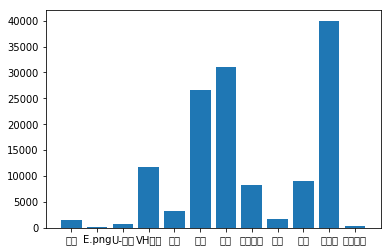

In [6]:
# domain number check


domain_dict = {}
for filename in filename_list:
    name = filename.split('/')[-1]
    domain = name.split('_')[3]
    try: domain_dict[domain] +=1
    except: domain_dict[domain] = 1

print (domain_dict)

x = []; y = []
for domain in domain_dict:
    x.append(domain)
    y.append(domain_dict[domain])
    
plt.bar(range(len(x)),y, tick_label=x)
plt.savefig(os.path.join(image_save_dir,'domain_bar.png'))
plt.show()

PCB dataset은 결함인지 아닌지 binary classification하는 문제이다. 더 자세하게 말하자면 에러일 것 같은 부분을 MV 알고리즘으로 잡고, 이것이 확실히 에러인지 아닌지 한 번 더 체크하는 것이다. 이 에러의 종류는 여러가지고 이 때문에 여러 도메인에 대해서 binary classification하는 task라고 볼 수 있다. 

lg innotek dataset은 MV에서 주시하고 있는 에러 종류(이후 domain이라고 표현)의 추가적인 정보가 파일 이름에 명시적으로 담겨있다.
이에 대해서 통계를 뽑으면 다음과 같다. 참고로 E.png의 카테고리는 domain 정보가 없는 파일들이다.


In [7]:
# image samples over domain

ok = OK_train + OK_test
ng = NG_train + NG_test
okng = {'OK': ok, 'NG': ng}

for on in okng.keys():
    print(on * 10)
    fl = okng[on]
    dic = {dom:[] for dom in domain_dict.keys()}
    
    for filename in fl:
        domain = filename.split('/')[-1].split('_')[3]
        dic[domain].append(filename)
    
    for ks in dic.keys():
        print(ks, len(dic[ks]))
    
    n_rows = len(dic.keys())
    n_cols = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows))

    for j in range(n_rows):
        c = list(dic.keys())[j]
        samples = np.random.choice(dic[c], size=n_cols, replace=False)
        for i in range(n_cols):
            file_path = samples[i]
            filename = file_path.split('/')[-1]
            image = imread(file_path)
            #image.resize((28,28,3))
            _ = axes[j, i].imshow(image)
            _ = axes[j, i].axis('off')
            _ = axes[j, i].set_title(filename)

    plt.savefig(os.path.join(image_save_dir, on + '_item_samples.png'), bbox_inches='tight')
    #plt.show()    

NGNGNGNGNGNGNGNGNGNG
핀홀 525
E.png 32
U-쇼트 65
VH결함 3600
돌기 1043
결손 3999
쇼트 20631
패드결함 1591
잔동 798
오픈 3936
선간폭 5485
홀내불량 97
OKOKOKOKOKOKOKOKOKOK
핀홀 924
E.png 132
U-쇼트 682
VH결함 8085
돌기 2212
결손 22709
쇼트 10465
패드결함 6753
잔동 903
오픈 5101
선간폭 34515
홀내불량 227


---

## 초기 학습 및 테스트 방법

### Architecture
- ResNet-18

### Optimization, Regularization

#### Parameter initialization

- He et al.의 normal initialization 방법을 채택함
    - He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015.
    
#### Gradient descent optimizer

- SGD + momentum

#### Training hyperparameters

- Batch size: 64
- Number of epochs: 100
- Initial learning rate: 0.05
- Momentum: 0.9
- Learning rate decay schedule: validation 성능이 plateau를 보일 때마다, 기존 learning rate를 decay 
    - learning rate patience = 10
    - validation score threshold: 1e-4
    - learning rate decay: 0.1
        - 위의 각 hyperparameters에 대한 설명의 경우, SuaLab 기술 블로그의 AlexNet 학습 부분 참조
- Batch sampling 방법: uniform sampling
        
#### Regularization

- L2 weight decay: 0.0001
- Data augmentation: LR flip, UD flip (4x augmentation)
    - Training 시에만 LR flip, UD flip, LR+UD flip 각각 25% 확률로 augmentation 수행
    - Test 시에는 augmentation을 수행하지 않음
- Batch normalization
    - 모든 conv layer와 ReLU layer 사이에 batch normalization을 적용

## 초기 분석 결과 및 체크리스트 관련 코멘트

In [25]:
# Load test set
test_list, anno_dict = dataset.read_lg_innotek_subset(root_dir, mode='test')
test_set = dataset.Dataset(root_dir, test_list, anno_dict)
print(len(test_set), type(test_set))
print(len(test_list))

57103 <class 'datasets.lg_innotek.Dataset'>
57103


In [9]:
""" Set test hyperparameters """
hp_d = dict()
mean = np.array([0.6196475, 0.58306944, 0.50553507], dtype=np.float32)
# fold 5: [ 0.63740861  0.60049582  0.52288377]
image_mean = np.transpose(np.tile(mean,(224,224,1)),[2,0,1])
hp_d['image_mean'] = image_mean

# Test hyperparameters
hp_d['batch_size'] = 256

In [10]:
""" Load weights and start test """
model = ConvNet([3, 224, 224], len(anno_dict['classes']), **hp_d)
model.logits.restore('/Data/checkpts/model_fold_2_trainval_1.dnn') # FIXME
evaluator = Evaluator()
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = model.predict(test_set, **hp_d)

total_time = time.time() - start_time

/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/cntk/core.py:82: RuntimeWarning: data is not C contiguous; rearrange your data/computation to avoid costly data conversions
  RuntimeWarning)


conv1.shape (64, 112, 112)
pool1.shape (64, 56, 56)
conv2_2.shape (64, 56, 56)
conv3_2.shape (128, 28, 28)
conv4_2.shape (256, 14, 14)
conv5_2.shape (512, 7, 7)
pool6.shape (512, 1, 1)


### Accuracy 측정 결과

In [11]:
print('Test error rate: {}'.format(test_score))

Test error rate: 0.13480166480654762


### Tact time 측정 결과

In [12]:
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))

Total tack time(sec): 93.28946352005005
Tact time per image(sec): 0.0016337051209227194


### Confusion matrix 결과

In [32]:
def conf_to_tex_table(confusion_matrix):
    temp = ''
    temp += '| |'
    for i in range(len(confusion_matrix[0])):
        temp += 'y^={}|'.format(i)
    temp += '\n'
    temp += '|-----|'
    for i in range(len(confusion_matrix[0])):
        temp += '-----|'.format(i)
    temp += '\n'
    ct = 0
    for row in confusion_matrix:
        temp += '|y={}|'.format(ct)
        for ele in row:
            temp += '{}|'.format(ele)
        temp += '\n'
        ct += 1
    return temp

| |y^=0|y^=1|
|-----|-----|-----|
|y=0|40559|5977|
|y=1|1737|8830|



In [35]:
print('Confusion matrix: \n{}'.format(confusion_matrix))

# repeat this w.r.t domain?
# e.g.
dic = {dom:[] for dom in domain_dict.keys()}

for filename in test_list:
    file = filename.split('/')[-1]
    domain = file.split('_')[3]
    dic[domain].append(file)
    
for ks in dic.keys():
    print(ks, len(dic[ks]))
    
for ks in dic.keys():
    data_list = dic[ks]
    data_set = dataset.Dataset(root_dir, data_list, anno_dict)
    _, _, score_data, conf_data = model.predict(data_set, **hp_d)
    print('-', ks,'\n\n Error Rate:', score_data, '\n\n Confusion Matrix: \n\n',conf_to_tex_table(conf_data))
    

Confusion matrix: 
[[40559  5977]
 [ 1737  8830]]
핀홀 711
E.png 53
U-쇼트 413
VH결함 5761
돌기 1648
결손 13120
쇼트 9785
패드결함 3843
잔동 523
오픈 3308
선간폭 17853
홀내불량 85
- 핀홀 
 Error Rate: 0.229212468593 
 Confusion Matrix: 

 | |y^=0|y^=1|
|-----|-----|-----|
|y=0|409|148|
|y=1|14|140|

- E.png 
 Error Rate: 0.188679245283 
 Confusion Matrix: 

 | |y^=0|y^=1|
|-----|-----|-----|
|y=0|42|9|
|y=1|1|1|

- U-쇼트 
 Error Rate: 0.131332105892 
 Confusion Matrix: 

 | |y^=0|y^=1|
|-----|-----|-----|
|y=0|350|43|
|y=1|11|9|

- VH결함 
 Error Rate: 0.134816312774 
 Confusion Matrix: 

 | |y^=0|y^=1|
|-----|-----|-----|
|y=0|3875|595|
|y=1|186|1105|

- 돌기 
 Error Rate: 0.176737882653 
 Confusion Matrix: 

 | |y^=0|y^=1|
|-----|-----|-----|
|y=0|1087|257|
|y=1|34|270|

- 결손 
 Error Rate: 0.134465144231 
 Confusion Matrix: 

 | |y^=0|y^=1|
|-----|-----|-----|
|y=0|10815|1432|
|y=1|334|539|

- 쇼트 
 Error Rate: 0.109216852227 
 Confusion Matrix: 

 | |y^=0|y^=1|
|-----|-----|-----|
|y=0|4028|610|
|y=1|449|4698|

- 패드결

### Performance - training set size plot

In [27]:
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Load results from pickle file
with open('../output/cv_lg_innotek_resnet_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)

In [28]:
test_score_per_train_portion = dict()
for fold_idx in test_result_dict.keys():
    for portion in test_result_dict[fold_idx].keys():
        if portion not in test_score_per_train_portion:
            test_score_per_train_portion[portion] = []
        test_score_per_train_portion[portion].append(test_result_dict[fold_idx][portion])
# test_score_per_train_portion
# >> {1.0: [result1 by fold1, result2 by fold2, ...], 0.75: [resutl1 by fold1, ...], ...}

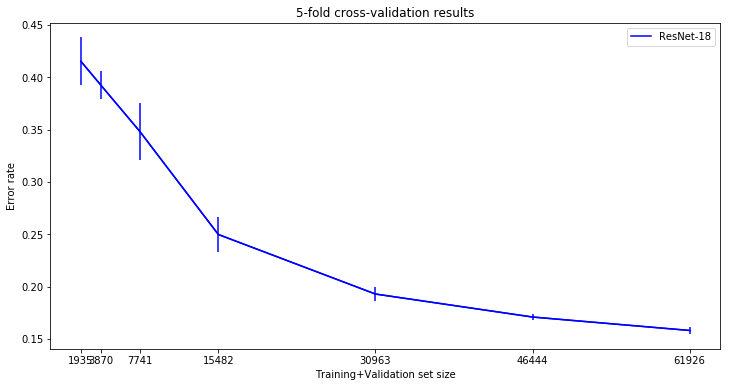

In [29]:
trainval_list, _ = dataset.read_lg_innotek_subset(root_dir, mode='train1')
total_set_size = len(trainval_list)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = [v*total_set_size for v in sorted(test_score_per_train_portion.keys())]
y_mean = [np.mean(l) for k, l in sorted(test_score_per_train_portion.items())]
y_std = [np.std(l) for k, l in sorted(test_score_per_train_portion.items())]
_ = ax.plot(x, y_mean, color='b', label='ResNet-18')
_ = ax.errorbar(x, y_mean, yerr=y_std, color='b')
_ = ax.set_title('5-fold cross-validation results')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Training+Validation set size')
_ = ax.set_xticks(x)
_ = plt.legend()

plt.savefig(os.path.join(image_save_dir, 'cross_validation_results.png'), bbox_inches='tight')
plt.show()
# >> output: accuracy graph averaged over 5 folds

### CAM visualization on the feature layer


Correct ones for class OK


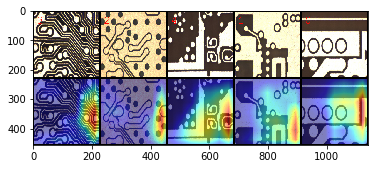

Wrong ones for class OK


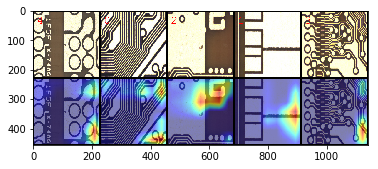

Correct ones for class NG


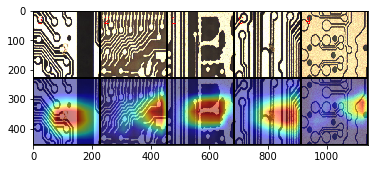

Wrong ones for class NG


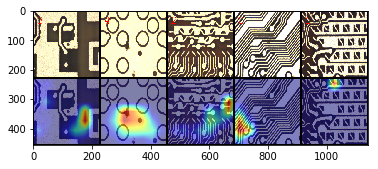

In [18]:
num_samples = 5 # FIXME

test_list_cor = []
test_list_wrn = []

for i in range(ys.shape[1]):
    correct = np.logical_and((ys.argmax(axis=1)==i),(y_preds.argmax(axis=1)==i))
    wrong = np.logical_and((ys.argmax(axis=1)==i),(y_preds.argmax(axis=1)!=i))
    test_list_cor.append(np.extract(correct, test_list))
    test_list_wrn.append(np.extract(wrong, test_list))
    
#print(len(test_list_cor))
#print(len(test_list_wrn))

test_list_cam = [test_list_cor, test_list_wrn]

for i in range(len(test_list_cor)):
    for j in range(2):
        corwrn = 'Correct' * (1-j) + 'Wrong' * j
        print('{} ones for class {}'.format(corwrn,anno_dict['classes'][str(i)]))
        try:
            filename_list = test_list_cam[j][i][0:num_samples]
            cam, X = grad_cam(model, dataset, root_dir, filename_list, anno_dict, i, 'conv5_2', **hp_d)
            img = view_image_cam_pairs(X, cam, n_samples=num_samples, border=2, n_cols=num_samples)
            imshow(img)
            plt.show()
            imsave(os.path.join(image_save_dir, 'class_{}_{}_grad_cam.jpg'.format(i,corwrn)), img)
        except:
            print('Not enough data for {} ones'.format(corwrn))


### T-SNE visualization on the feature layer

In [36]:
test_list_sample = np.random.choice(test_list, size=5000, replace=False)
test_feature_maps, images, test_labels = get_feature_maps(model, dataset, root_dir, test_list_sample, anno_dict, 'conv5_2', **hp_d)
print(test_feature_maps.shape)

(5000, 512, 7, 7)


In [37]:
# Flatten feature maps into feature vectors
test_features = test_feature_maps.reshape((test_feature_maps.shape[0], -1))
print(test_features.shape)

(5000, 25088)


In [38]:
import time
tic = time.time()
test_embeddings = TSNE(n_components=2, verbose=1).fit_transform(test_features)
toc = time.time()
print('TSNE takes {} secs'.format(toc-tic))
print(test_embeddings.shape)
np.save('./test_embeddings.npy',test_embeddings)
#test_embeddings = np.load('./test_embeddings.npy')

# if it takes too much time, reduce data into half, or etc.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 4.218s...
[t-SNE] Computed neighbors for 5000 samples in 786.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.772998
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.220200
[t-SNE] Error after 1000 iterations: 2.575217
TSNE takes 860.5860698223114 secs
(5000, 2)


In [39]:
from datasets.utils import view_tsne_embeddings

In [40]:
#images = np.ones((17386,3,28,28)) # (N,C,H,W)
emb_image = view_tsne_embeddings(test_embeddings, images, test_labels)
imsave(os.path.join(image_save_dir, 'convnet_embed.jpg'), emb_image)

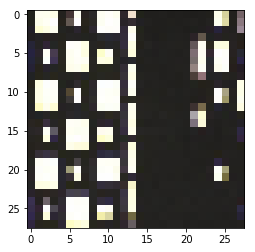

In [24]:
from skimage.transform import resize
img = images[0]
img = np.transpose(img, [1,2,0])
im = resize(img,(28,28),mode='constant')
im.shape
imshow(im)
plt.show()

In [ ]:
# refer
#
#dic = {dom:{'OK':[], 'NG':[]} for dom in domain_dict.keys()}

#for filename in filename_list:
#    domain = filename.split('/')[-1].split('_')[3]
#    label = filename.split('/')[-1].split('_')[1]
#    dic[domain][label].append(filename)
    
#for ks in dic.keys():
#    for ks2 in dic[ks].keys():
#        print(ks, ks2, len(dic[ks][ks2]))
    
#n_rows = len(dic.keys())
#n_cols = 5
#fig, axes = plt.subplots(n_rows, 2 * n_cols, figsize=(4*n_cols,3*n_rows))

#for j in range(n_rows):
#    c = list(dic.keys())[j]
#    samples_ok = np.random.choice(dic[c]['OK'], size=n_cols, replace=False)
#    samples_ng = np.random.choice(dic[c]['NG'], size=n_cols, replace=False)
#    samples = np.concatenate((samples_ok, samples_ng),axis=0)
#    for i in range(2 * n_cols):
#        file_path = samples[i]
#        filename = file_path.split('/')[-1]
#        image = imread(file_path)
#        #image.resize((28,28,3))
#        _ = axes[j, i].imshow(image)
#        _ = axes[j, i].axis('off')
#        _ = axes[j, i].set_title(filename)
#
#plt.savefig(os.path.join(image_save_dir, 'item_samples.png'), bbox_inches='tight')
#plt.show()